In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

True
NVIDIA GeForce RTX 3050 Ti Laptop GPU
[]


In [1]:
import os
import numpy as np
import tensorflow as tf
import cv2
import shap
import lime
import matplotlib.pyplot as plt
import lime.lime_image
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K
import pickle  # For saving training history


In [7]:
# Dataset Paths
train_dir = "D:/Project Exhibition II/Dataset/Final Dataset"
test_dir = "D:/Project Exhibition II/Dataset/pred"

# Parameters
epochs = 1
batch_size = 16
input_shape = (150, 150, 1)  # Grayscale images
classes = 2 # Yes and No
activation = 'relu'
optimizer = Adam(learning_rate=0.001)

# Modified ImageDataGenerator with data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,             # Normalization 
    validation_split=0.2,       # Validation split 
    rotation_range=15,          # Randomly rotate images by up to 15 degrees
    width_shift_range=0.1,      # Randomly shift images horizontally by up to 10%
    height_shift_range=0.1,     # Randomly shift images vertically by up to 10%
    zoom_range=0.1,             # Randomly zoom in/out by up to 10%
    horizontal_flip=True,       # Randomly flip images horizontally
    fill_mode='nearest'         # Strategy to fill points outside the input boundaries
)


train_generator = datagen.flow_from_directory(
    train_dir, 
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale',
    subset='training'
)

# For validation, it's often better to use non-augmented images
# to get a realistic evaluation of model performance
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

val_generator = val_datagen.flow_from_directory(
    train_dir, 
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale',
    subset='validation'
)


Found 2400 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [8]:
def build_model():
    model = Sequential([
        Conv2D(32, (3,3), activation=activation, input_shape=input_shape),
        MaxPooling2D(2,2),
        
        Conv2D(64, (3,3), activation=activation),
        MaxPooling2D(2,2),
        
        Flatten(),
        Dense(128, activation=activation),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_model()
model.summary()


d:\anaconda3\envs\Project\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    10,616,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,635,905 (40.57 MB)

 Trainable params: 10,635,905 (40.57 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
checkpoint_path = "brain_tumor_checkpoint.h5"

# Check if checkpoint exists
if os.path.exists(checkpoint_path):
    print("📌 Loading saved model...")
    model.load_weights(checkpoint_path)
else:
    print("🚀 Training new model...")

checkpoint_callback = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_accuracy', mode='max')

#Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model with both callbacks
history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, callbacks=[checkpoint_callback, early_stopping])

# Save training history
with open("training_history.pkl", "wb") as f:
    pickle.dump(history.history, f)

print("✅ Model training completed and saved!")


📌 Loading saved model...
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.9520 - loss: 0.1454

150/150 ━━━━━━━━━━━━━━━━━━━━ 49s 317ms/step - accuracy: 0.9520 - loss: 0.1454 - val_accuracy: 0.9417 - val_loss: 0.2872
✅ Model training completed and saved!


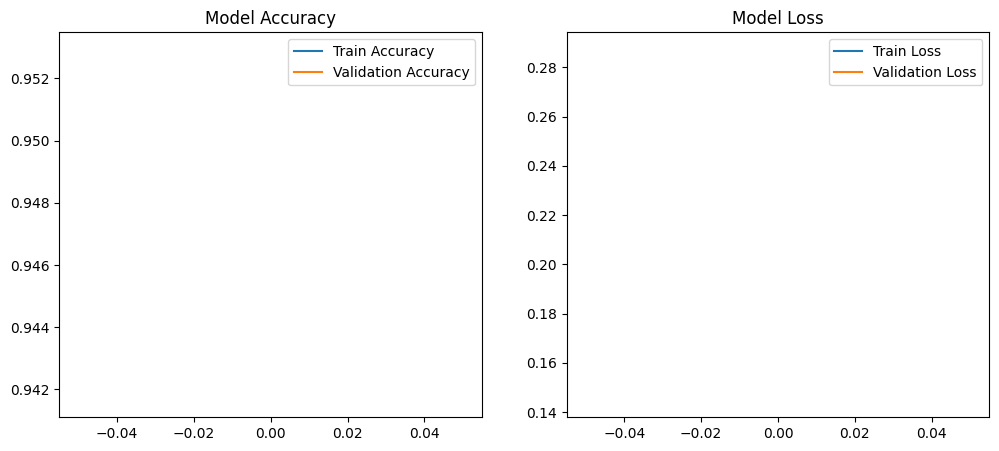

In [10]:
# Load history
with open("training_history.pkl", "rb") as f:
    history = pickle.load(f)

# Plot Accuracy & Loss Graphs
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Model Accuracy")

plt.subplot(1,2,2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Model Loss")

plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


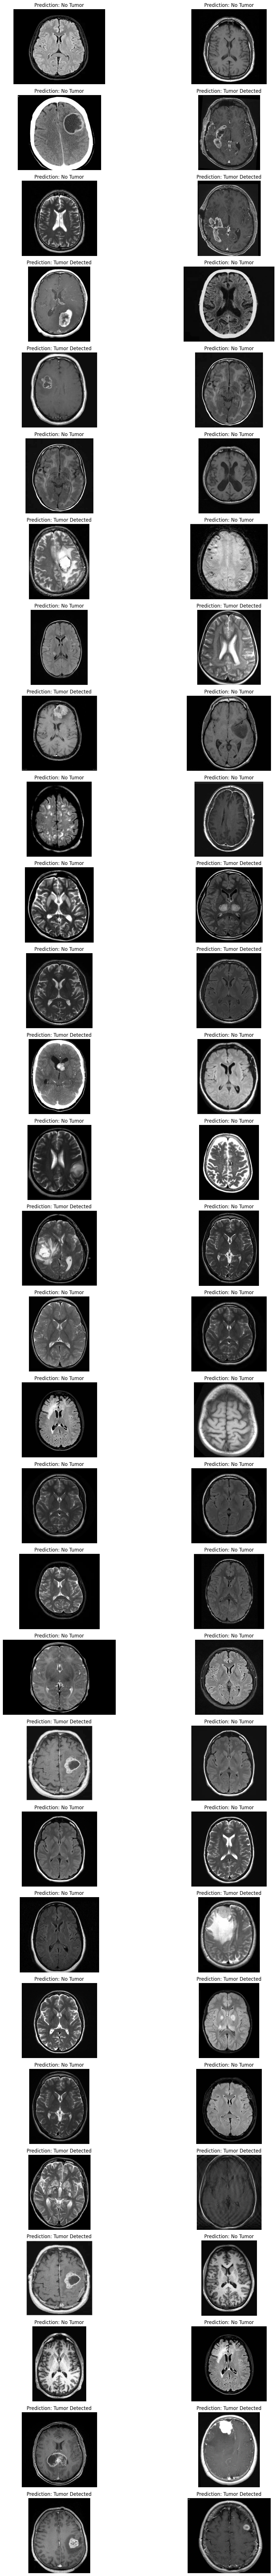

{'pred0.jpg': 'No Tumor', 'pred1.jpg': 'No Tumor', 'pred10.jpg': 'No Tumor', 'pred11.jpg': 'Tumor Detected', 'pred12.jpg': 'No Tumor', 'pred13.jpg': 'Tumor Detected', 'pred14.jpg': 'Tumor Detected', 'pred15.jpg': 'No Tumor', 'pred16.jpg': 'Tumor Detected', 'pred17.jpg': 'No Tumor', 'pred18.jpg': 'No Tumor', 'pred19.jpg': 'No Tumor', 'pred2.jpg': 'Tumor Detected', 'pred20.jpg': 'No Tumor', 'pred21.jpg': 'No Tumor', 'pred22.jpg': 'Tumor Detected', 'pred23.jpg': 'Tumor Detected', 'pred24.jpg': 'No Tumor', 'pred25.jpg': 'No Tumor', 'pred26.jpg': 'No Tumor', 'pred27.jpg': 'No Tumor', 'pred28.jpg': 'Tumor Detected', 'pred29.jpg': 'No Tumor', 'pred3.jpg': 'Tumor Detected', 'pred30.jpg': 'Tumor Detected', 'pred31.jpg': 'No Tumor', 'pred32.jpg': 'No Tumor', 'pred33.jpg': 'No Tumor', 'pred34.jpg': 'Tumor Detected', 'pred35.jpg': 'No Tumor', 'pred36.jpg': 'No Tumor', 'pred37.jpg': 'No Tumor', 'pred38.jpg': 'No Tumor', 'pred39.jpg': 'No Tumor', 'pred4.jpg': 'No Tumor', 'pred40.jpg': 'No Tumor', 'p

In [11]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


def predict_tumor_batch(folder_path, model):
    image_paths = [os.path.join(folder_path, fname) for fname in os.listdir(folder_path) if fname.endswith(('.png', '.jpg', '.jpeg'))]

    if not image_paths:
        print("❌ No valid images found in the directory!")
        return

    images = []
    processed_paths = []
    
    for img_path in image_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"❌ Could not load image: {img_path}")
            continue
        
        img = cv2.resize(img, (150, 150))  # Resize to match model input
        img = np.expand_dims(np.expand_dims(img, axis=-1), axis=0) / 255.0
        img = img.reshape(150, 150, 1)  # Add channel dimension
        images.append(img)
        processed_paths.append(img_path)
    
    if not images:
        print("❌ No valid images could be processed!")
        return
    
    images = np.array(images)  # Convert list to NumPy array
    predictions = model.predict(images)  # Predict all images at once

    plt.figure(figsize=(12, len(images) * 3))
    
    for i, (img_path, pred) in enumerate(zip(processed_paths, predictions)):
        label = "Tumor Detected" if pred >= 0.5 else "No Tumor"
        
        plt.subplot(len(images), 2, i + 1)
        plt.imshow(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE), cmap='gray')
        plt.title(f"Prediction: {label}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

    # Return dictionary of results
    return {os.path.basename(path): ("Tumor Detected" if pred >= 0.5 else "No Tumor") for path, pred in zip(processed_paths, predictions)}

# Example Usage:
predictions = predict_tumor_batch("D:/Project Exhibition II/Dataset/pred", model)
print(predictions)  # Print results


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


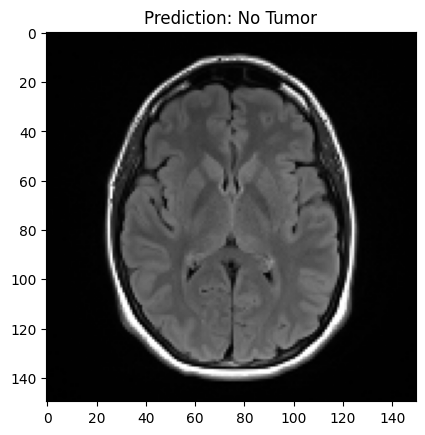

'No Tumor'

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def predict_tumor(image_path, model):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (150, 150))  # Adjust size to match training input
    img = np.expand_dims(np.expand_dims(img, axis=-1), axis=0) / 255.0

    prediction = model.predict(img)[0][0]  # Extract scalar probability
    label = "Tumor Detected" if prediction >= 0.5 else "No Tumor"

    plt.imshow(img[0, :, :, 0], cmap='gray')
    plt.title(f"Prediction: {label}")
    plt.show()

    return label


# Predict on a sample image (Change path accordingly)
predict_tumor("D:/Project Exhibition II/Dataset/pred/pred47.jpg", model)



d:\anaconda3\envs\Project\lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
d:\anaconda3\envs\Project\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_9
Received: inputs=['Tensor(shape=(10, 150, 150, 1))']
  warnings.warn(msg)
d:\anaconda3\envs\Project\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_9
Received: inputs=['Tensor(shape=(20, 150, 150, 1))']
  warnings.warn(msg)
d:\anaconda3\envs\Project\lib\site-

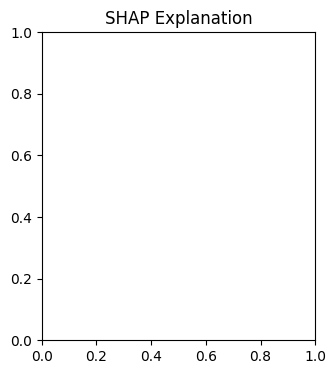

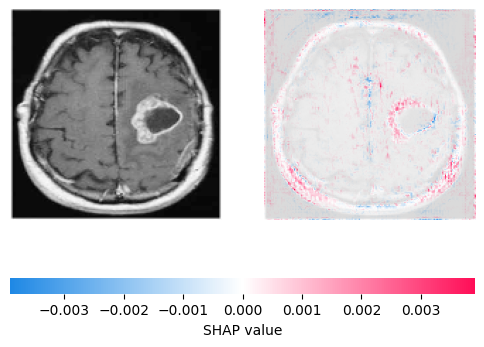

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


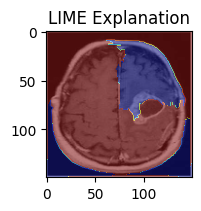

In [18]:
import cv2
import shap
import lime
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import quickshift
import tensorflow as tf

# Ensure the model is initialized with a dummy input
dummy_input = np.random.rand(1, 150, 150, 1).astype(np.float32)
_ = model(dummy_input)

def explain_model(image_path, model, train_generator, layer_name="conv2d_2"):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        print("❌ Error: Could not load image. Check file path!")
        return None

    # Resize and normalize image
    img = cv2.resize(img, (150, 150))
    img = np.expand_dims(img, axis=-1)  # Add channel dimension (150,150,1)
    img = np.expand_dims(img, axis=0) / 255.0  # Add batch dimension (1,150,150,1)

    # SHAP Explanation
    background = next(train_generator)[0][:10]  # Use 10 training images as background
    explainer = shap.DeepExplainer(model, background)
    shap_values = explainer.shap_values(img)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("SHAP Explanation")
    shap.image_plot(shap_values, img)

    # LIME Explanation
    explainer = lime.lime_image.LimeImageExplainer()

    # Convert grayscale image to 3-channel for LIME
    img_rgb = np.repeat(img, 3, axis=-1)  # Convert (1,150,150,1) → (1,150,150,3)

    def model_predict(imgs):
        imgs = np.array(imgs)  # Convert list to NumPy array
        imgs = np.mean(imgs, axis=-1, keepdims=True)  # Convert RGB back to grayscale (batch, 150,150,1)
        return model.predict(imgs)  # Ensure correct batch shape (batch, 150,150,1)

    explanation = explainer.explain_instance(
        img_rgb[0],  # Remove batch dimension for LIME
        model_predict, 
        top_labels=1, 
        hide_color=0, 
        num_samples=100,
        segmentation_fn=lambda x: quickshift(x, kernel_size=4, max_dist=200, ratio=0.2)
    )

    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0], 
        positive_only=True, 
        num_features=5, 
        hide_rest=False
    )

    plt.subplot(1, 3, 2)
    plt.imshow(temp, cmap="gray")
    plt.imshow(mask, cmap="jet", alpha=0.5)
    plt.title("LIME Explanation")

    plt.show()

# Call the function with train_generator
explain_model("D:/Project Exhibition II/Dataset/pred/pred56.jpg", model, train_generator)
